In [0]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm # not available on Kaggle Kernel
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM


In [0]:
import datetime as dt
import os

In [0]:
pd.__version__

'0.24.2'

In [0]:
# 1x_uN2NhXl2-o9YF3J0GyLcxxNGkPXU9h

In [0]:
if not os.path.exists('ms_proj'):
  os.makedirs('ms_proj')
%cd ms_proj
if not os.path.exists('data'):
  os.makedirs('data')
%cd data

/content/ms_proj
/content/ms_proj/data


In [0]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

In [0]:
file_id = r'1x_uN2NhXl2-o9YF3J0GyLcxxNGkPXU9h'
destination = r'cleaned_data.csv'


In [0]:
download_file_from_google_drive(file_id, destination)

In [0]:
# Set some parameters to get good visuals - style to ggplot and size to 15,10
plt.style.use('ggplot')
import matplotlib.style as style
style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 8)

In [0]:
# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

In [0]:
df = pd.read_csv('cleaned_data.csv')

In [0]:
df['@timestamp'] = pd.to_datetime(df['@timestamp'])

In [0]:
df['@timestamp.1'] = pd.to_datetime(df['@timestamp.1'])

In [0]:
df.loc[df['@timestamp.1'] != df['@timestamp']]

,@timestamp,_id,@timestamp.1


In [0]:
df.head()

,@timestamp,_id,@timestamp.1
0,2019-06-16 05:47:55,tKvTXmsB7mP0GwVz7j3l,2019-06-16 05:47:55
1,2019-06-16 05:47:49,g9XTXmsBoTGddM7v1xhz,2019-06-16 05:47:49
2,2019-06-16 05:47:45,b6vTXmsB7mP0GwVzxzvX,2019-06-16 05:47:45
3,2019-06-16 05:47:39,_qvTXmsB7mP0GwVzsDln,2019-06-16 05:47:39
4,2019-06-16 05:47:35,AdXTXmsBoTGddM7voBbC,2019-06-16 05:47:35


In [0]:
df['date'] = df['@timestamp'].dt.date


In [0]:
df['hour'] = df['@timestamp'].dt.hour

In [0]:
df['minute'] = df['@timestamp'].dt.minute

In [0]:
df_counts = df.groupby(['date', 'hour', 'minute'])['_id'].count().reset_index()

In [0]:
df_counts.iloc[0]['date'].strftime('%Y-%m-%d')+" "+str(df_counts.iloc[0]['hour'])+":"+str(df_counts.iloc[0]['minute'])+":00"

'2019-06-09 20:47:00'

In [0]:
df_counts['date_trunc'] = pd.to_datetime(df_counts.apply(lambda row: row['date'].strftime('%Y-%m-%d')+" "+str(row['hour'])+":"+str((row['minute']//10)*10)+":00", axis=1))

In [0]:
df_counts

,date,hour,minute,_id,date_trunc
0,2019-06-09,20,47,12,2019-06-09 20:40:00
1,2019-06-09,20,48,12,2019-06-09 20:40:00
2,2019-06-09,20,49,12,2019-06-09 20:40:00
3,2019-06-09,20,50,12,2019-06-09 20:50:00
4,2019-06-09,20,51,12,2019-06-09 20:50:00
5,2019-06-09,20,52,12,2019-06-09 20:50:00
6,2019-06-09,20,53,12,2019-06-09 20:50:00
7,2019-06-09,20,54,12,2019-06-09 20:50:00
8,2019-06-09,20,55,12,2019-06-09 20:50:00
9,2019-06-09,20,56,12,2019-06-09 20:50:00


In [0]:
df_counts_final = df_counts.groupby('date_trunc')['_id'].sum().reset_index()

/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fae2038dbe0> has a label of '_id' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


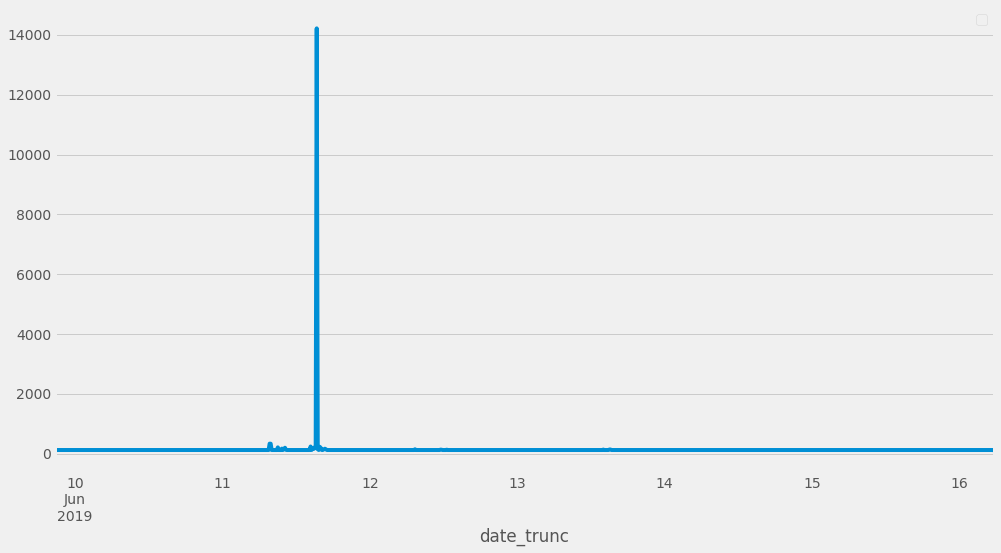

In [0]:
df_counts_final.plot(x='date_trunc', y='_id')

In [0]:
df_counts_final.sort_values('_id', ascending=False).head()

,date_trunc,_id
256,2019-06-11 15:20:00,14220
210,2019-06-11 07:40:00,332
211,2019-06-11 07:50:00,331
255,2019-06-11 15:10:00,279
250,2019-06-11 14:20:00,237


In [0]:
df_counts_final = df_counts_final.loc[df_counts_final['_id']<1000]

In [0]:
df = df_counts_final.copy()

In [0]:
df = df.rename(columns={'_id':'count'})

In [0]:
df['hours'] = df['date_trunc'].dt.hour
df['minutes'] = (df['date_trunc'].dt.minute//10 < 3).astype(int)
df['daylight'] = ((df['hours'] >= 6) & (df['hours'] <= 22)).astype(int)

In [0]:
df.head(10)

,date_trunc,count,hours,minutes,daylight
0,2019-06-09 20:40:00,36,20,0,1
1,2019-06-09 20:50:00,120,20,0,1
2,2019-06-09 21:00:00,120,21,1,1
3,2019-06-09 21:10:00,120,21,1,1
4,2019-06-09 21:20:00,120,21,1,1
5,2019-06-09 21:30:00,120,21,0,1
6,2019-06-09 21:40:00,120,21,0,1
7,2019-06-09 21:50:00,120,21,0,1
8,2019-06-09 22:00:00,120,22,1,1
9,2019-06-09 22:10:00,120,22,1,1


In [0]:
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['date_trunc'].dt.dayofweek
# df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)


In [0]:
df['time_epoch'] = (df['date_trunc'].astype(np.int64)/100000000000).astype(np.int64)

In [0]:
# df['categories'] = df['WeekDay']*2 + df['daylight']

In [0]:
data = df[['count', 'hours', 'minutes']] #'DayOfTheWeek',, 'WeekDay', , 'minutes'
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2, random_state=123)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

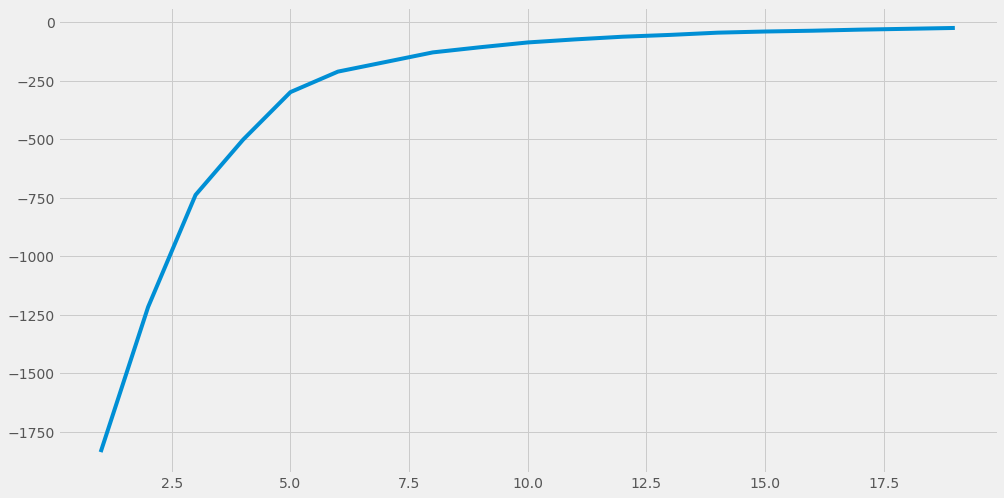

In [0]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i, random_state=123).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [0]:
cluster_model = kmeans[14]

In [0]:
df['cluster'] = cluster_model.predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

8     129
1     103
4      95
0      90
3      88
10     85
14     84
12     83
5      81
13     63
11      6
7       5
2       3
6       2
9       1
Name: cluster, dtype: int64

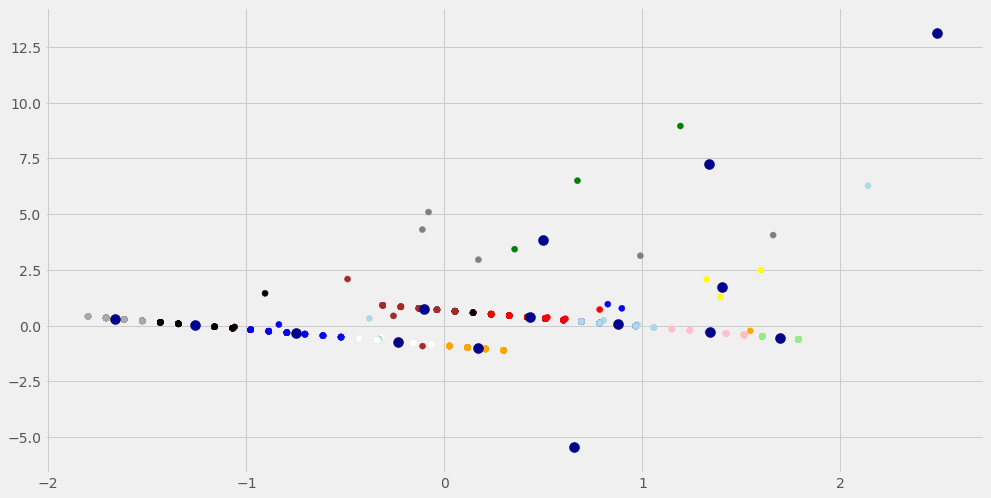

In [0]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 
          11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
ax.scatter(cluster_model.cluster_centers_[:,0], cluster_model.cluster_centers_[:,1], s=100, c='darkblue')
plt.show()

In [0]:
outliers_fraction = 0.003

In [0]:
distance = getDistanceByPoint(data, cluster_model)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [0]:
df

,date_trunc,count,hours,minutes,daylight,DayOfTheWeek,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21
0,2019-06-09 20:40:00,36,20,0,1,6,15601128,9,0.656561,-5.453772,0.0
1,2019-06-09 20:50:00,120,20,0,1,6,15601134,3,1.513623,-0.416281,0.0
2,2019-06-09 21:00:00,120,21,1,1,6,15601140,5,0.116955,-0.981054,0.0
3,2019-06-09 21:10:00,120,21,1,1,6,15601146,5,0.116955,-0.981054,0.0
4,2019-06-09 21:20:00,120,21,1,1,6,15601152,5,0.116955,-0.981054,0.0
5,2019-06-09 21:30:00,120,21,0,1,6,15601158,13,1.604871,-0.482634,0.0
6,2019-06-09 21:40:00,120,21,0,1,6,15601164,13,1.604871,-0.482634,0.0
7,2019-06-09 21:50:00,120,21,0,1,6,15601170,13,1.604871,-0.482634,0.0
8,2019-06-09 22:00:00,120,22,1,1,6,15601176,5,0.208204,-1.047407,0.0
9,2019-06-09 22:10:00,120,22,1,1,6,15601182,5,0.208204,-1.047407,0.0


In [0]:
df = df.dropna()

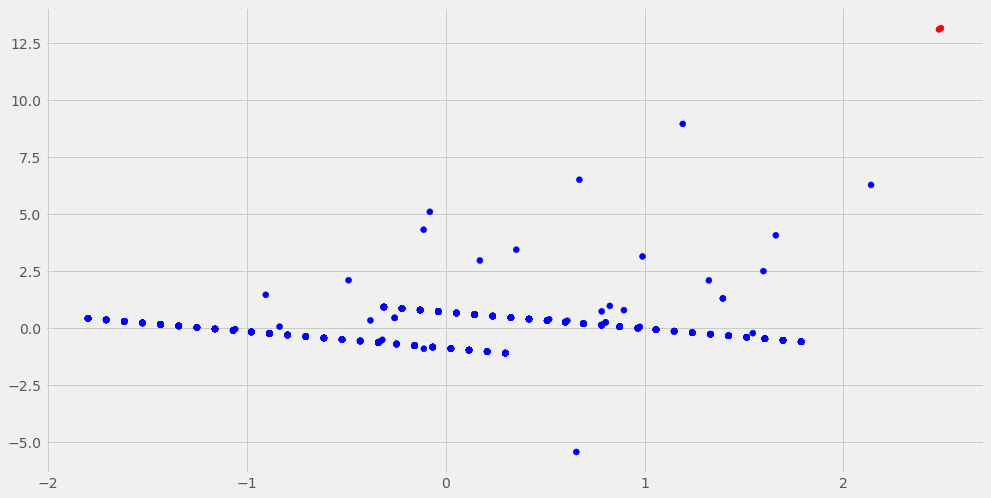

In [0]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

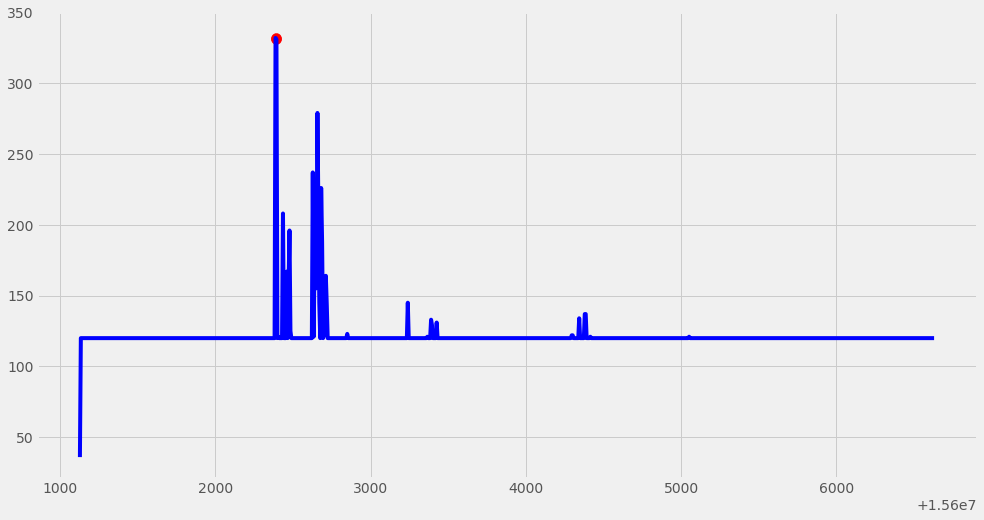

In [0]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'count']] #anomaly
# b = df.loc[df['count'] >30000, ['time_epoch', 'count']] #missed

ax.plot(df['time_epoch'], df['count'], color='blue')
ax.scatter(a['time_epoch'],a['count'], color='red', s=100)
# ax.scatter(b['time_epoch'],b['count'], color='red', s=100)
plt.show()

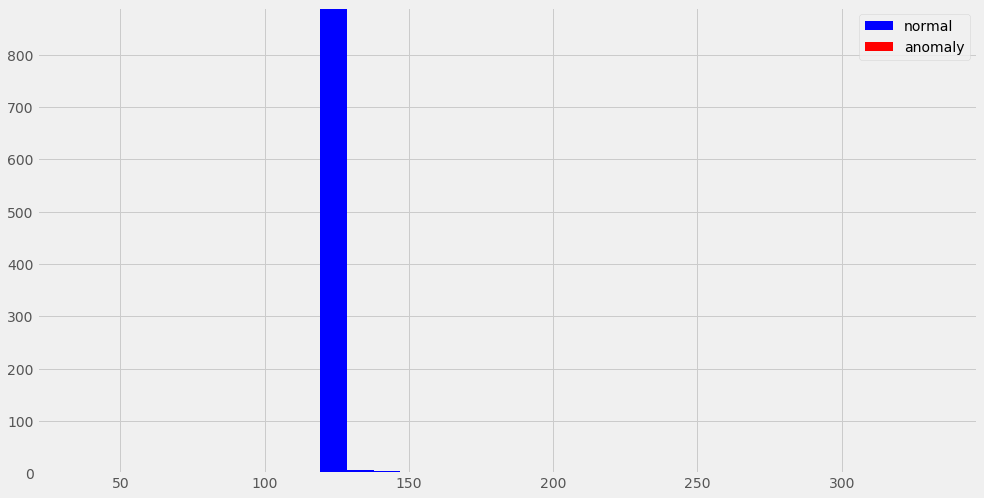

In [0]:
a = df.loc[df['anomaly21'] == 0, 'count']
b = df.loc[df['anomaly21'] == 1, 'count']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()


## Isolated forests

In [0]:
outliers_fraction = 0.005

In [0]:
# Take useful feature and standardize them 
data = df[['count', 'hours', 'daylight']] # 'DayOfTheWeek', 'WeekDay'
# data = df[['principal_feature1', 'principal_feature2']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0.0    911
1.0      5
Name: anomaly25, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


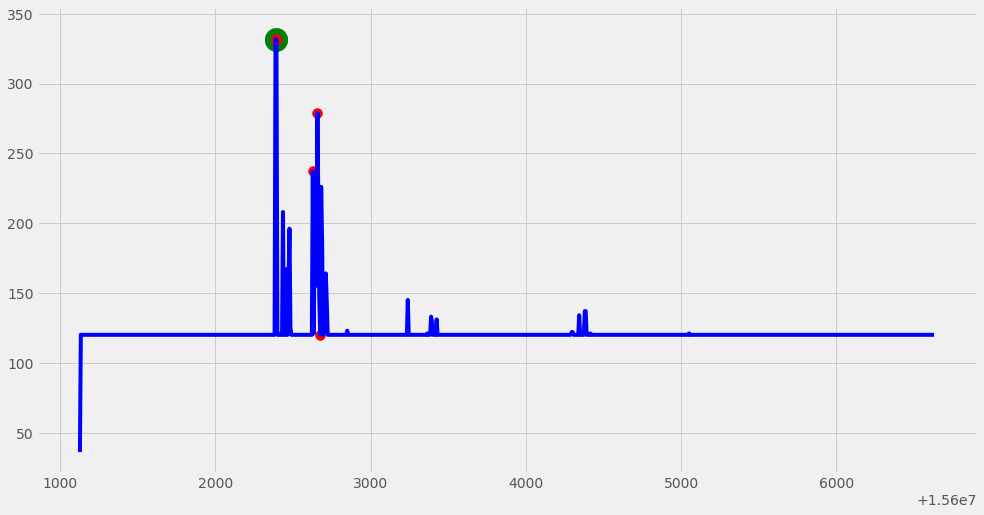

In [0]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'count']] #anomaly
b = df.loc[df['anomaly21']==1, ['time_epoch', 'count']]

ax.plot(df['time_epoch'], df['count'], color='blue')
ax.scatter(b['time_epoch'],b['count'], color='green', s=500)
ax.scatter(a['time_epoch'],a['count'], color='red', s=100)

plt.show()

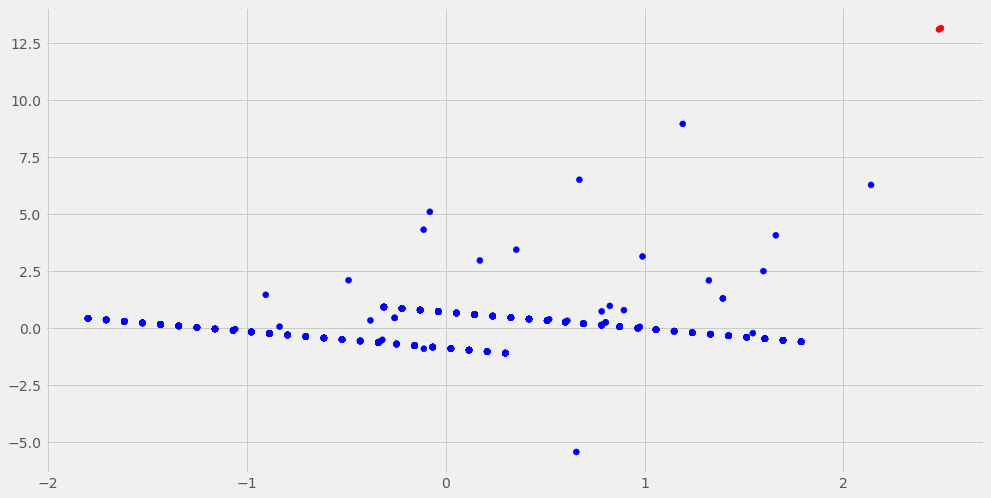

In [0]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

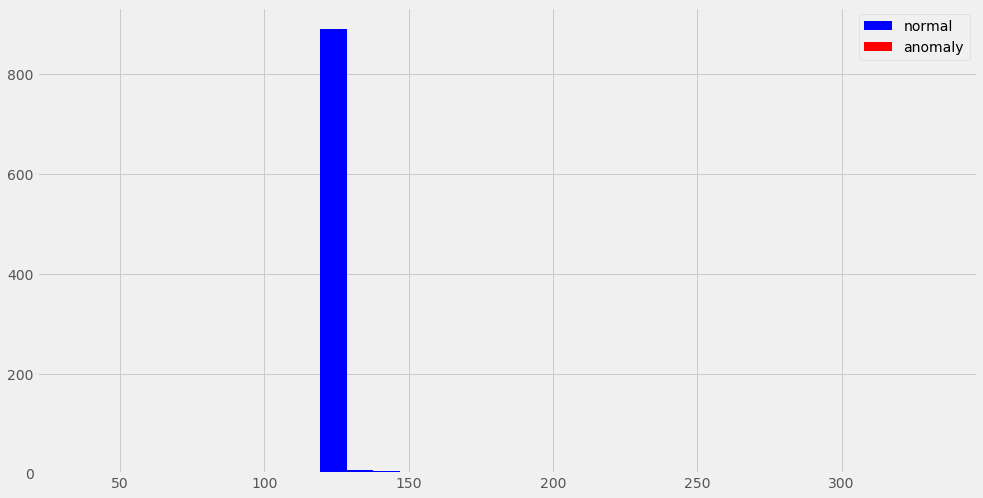

In [0]:
a = df.loc[df['anomaly25'] == 0, 'count']
b = df.loc[df['anomaly25'] == 1, 'count']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

## SVM

In [0]:
# Take useful feature and standardize them 
data = df[['count', 'hours', 'daylight', 'DayOfTheWeek']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)

In [0]:
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0.0    877
1.0     39
Name: anomaly26, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


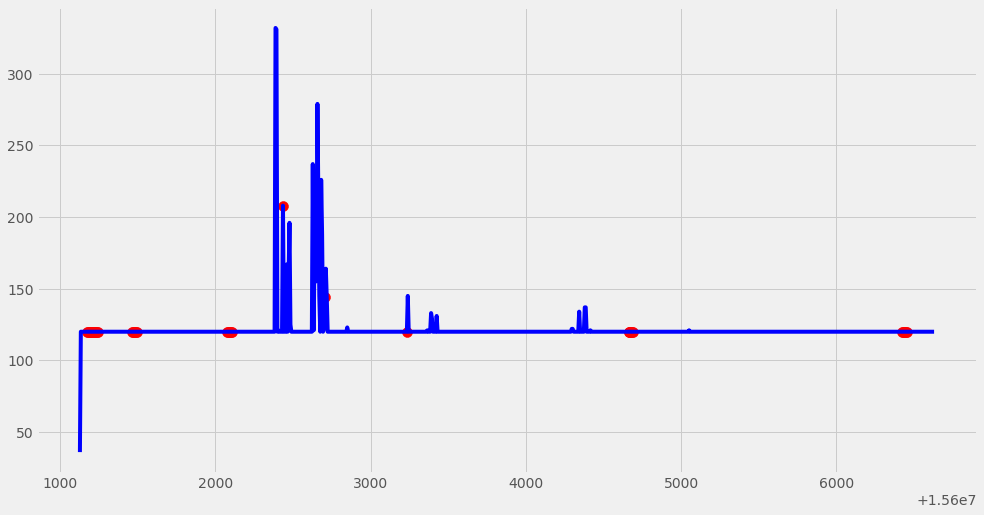

In [0]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['time_epoch', 'count']] #anomaly

ax.plot(df['time_epoch'], df['count'], color='blue')
ax.scatter(a['time_epoch'],a['count'], color='red', s=100)
plt.show()

KeyError: ignored

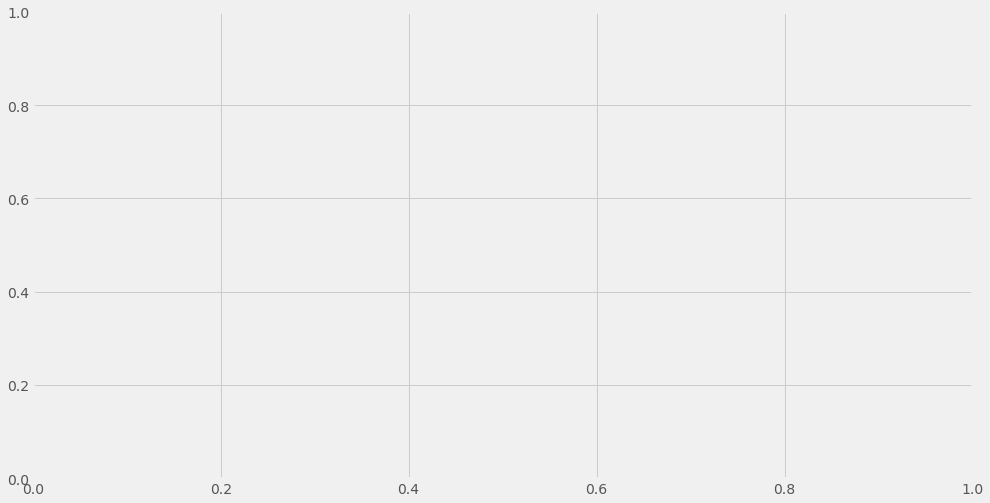

In [0]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly26"].apply(lambda x: colors[x]))
plt.show()

## RNNs

In [0]:
#select and standardize data
data_n = df[['count', 'hours', 'minutes']]#'daylight', 'DayOfTheWeek', 'WeekDay'
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In [0]:
# important parameters and train/test size
prediction_time = 1 
testdatasize = 50
unroll_length = 10
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

# test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [0]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

In [0]:
# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (845, 10, 3)
y_train (845,)
x_test (50, 10, 3)
y_test (50,)


In [0]:
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys

Using TensorFlow backend.


In [0]:
# Build the model
model = Sequential()

model.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=10,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    200,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

W0703 07:17:05.331677 140386695944064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 3), units=10)`
  
W0703 07:17:05.375303 140386695944064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0703 07:17:05.383761 140386695944064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend

compilation time : 0.02914595603942871


In [0]:
model.fit(
    x_train,
    y_train,
    batch_size=1000,
    nb_epoch=30,
    validation_split=0.1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
W0703 07:17:06.264804 140386695944064 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0703 07:17:07.611929 140386695944064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 760 samples, validate on 85 samples
Epoch 1/30
760/760 [==============================] - 2s 3ms/step - loss: 1.1611 - val_loss: 0.0218
Epoch 2/30
760/760 [==============================] - 0s 386us/step - loss: 1.1401 - val_loss: 0.0152
Epoch 3/30
760/760 [==============================] - 0s 376us/step - loss: 1.1239 - val_loss: 0.0193
Epoch 4/30
760/760 [==============================] - 0s 380us/step - loss: 1.1074 - val_loss: 0.0134
Epoch 5/30
760/760 [==============================] - 0s 385us/step - loss: 1.0912 - val_loss: 0.0269
Epoch 6/30
760/760 [==============================] - 0s 369us/step - loss: 1.0961 - val_loss: 0.0058
Epoch 7/30
760/760 [==============================] - 0s 372us/step - loss: 1.0991 - val_loss: 0.0216
Epoch 8/30
760/760 [==============================] - 0s 363us/step - loss: 1.0832 - val_loss: 0.0143
Epoch 9/30
760/760 [==============================] - 0s 369us/step - loss: 1.0743 - val_loss: 0.0179
Epoch 10/30
760/760 [==================

In [0]:
diff=[]
ratio=[]
p = model.predict(x_test)

In [0]:
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

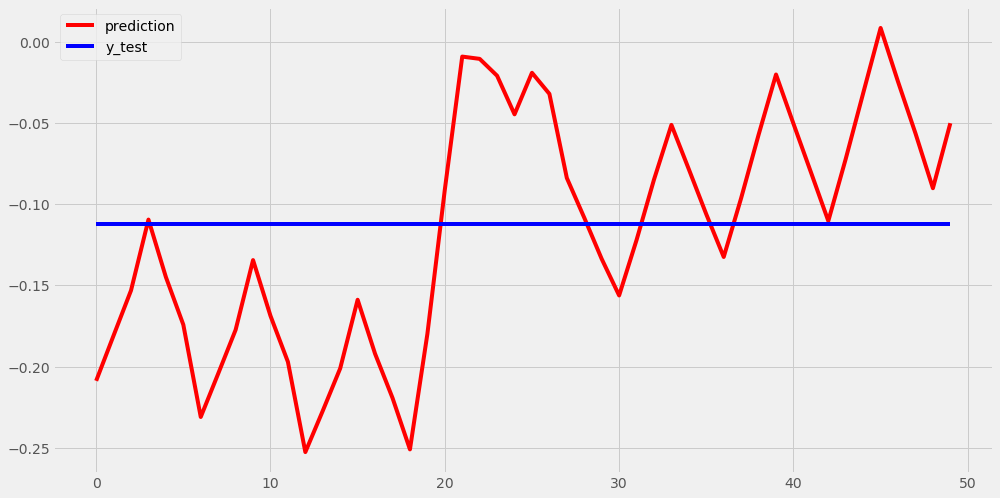

In [0]:
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [0]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(0.1*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

In [0]:
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)

In [0]:
test.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [0]:
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))

In [0]:
complement.shape

(867,)

In [0]:
# # add the data to the main
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0.0    911
1.0      5
Name: anomaly27, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


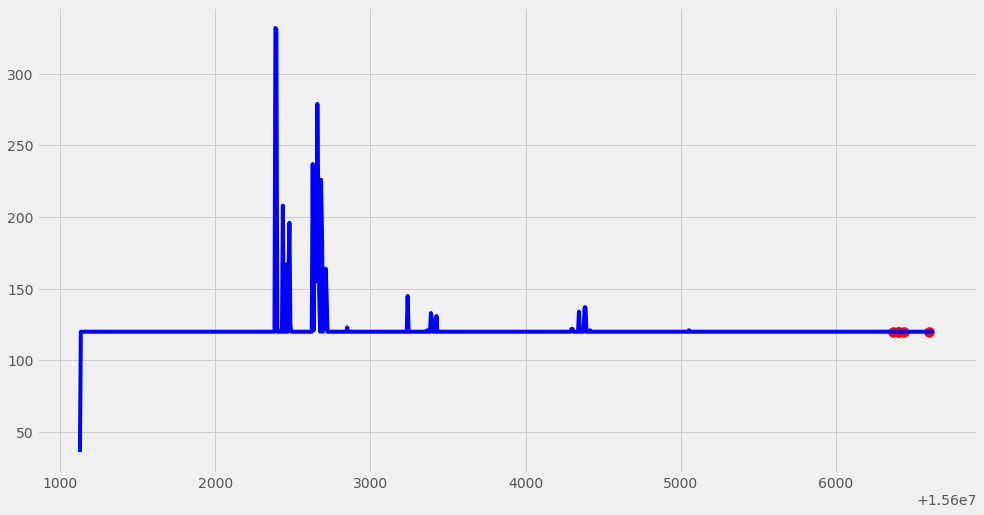

In [0]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'count']] #anomaly

ax.plot(df['time_epoch'], df['count'], color='blue')
ax.scatter(a['time_epoch'],a['count'], color='red', s=100)
# plt.axis([1.370*1e7, 1.405*1e7, -2.5,1])
plt.show()

In [0]:
diff=[]
ratio=[]
p = model.predict(x_train)

In [0]:
for u in range(len(y_train)):
    pr = p[u][0]
    ratio.append((y_train[u]/pr)-1)
    diff.append(abs(y_train[u]- pr))

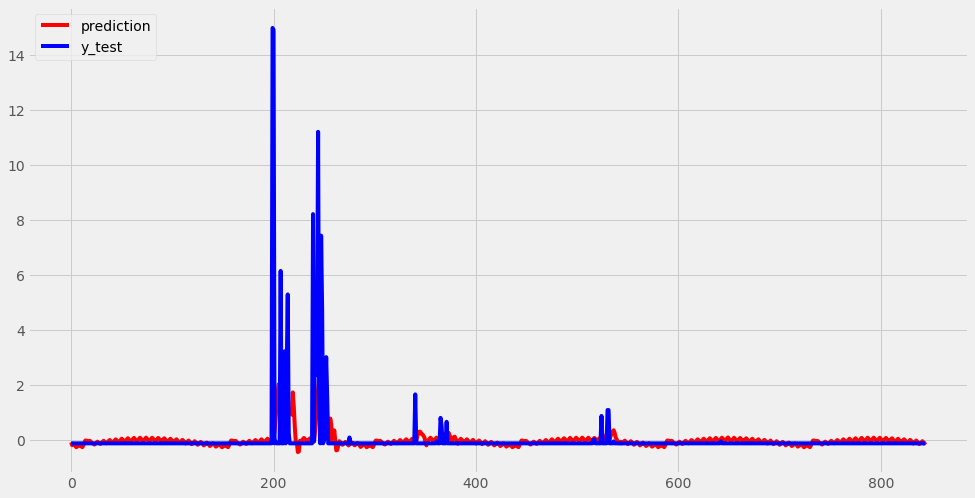

In [0]:
fig, axs = plt.subplots()
axs.plot(p,color='red', label='prediction')
axs.plot(y_train,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()

In [0]:
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(0.01*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

In [0]:
diff.shape

(845,)

In [0]:
diff.index

RangeIndex(start=0, stop=845, step=1)

In [0]:
complement.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


0    909
1      8
Name: anomaly28, dtype: int64


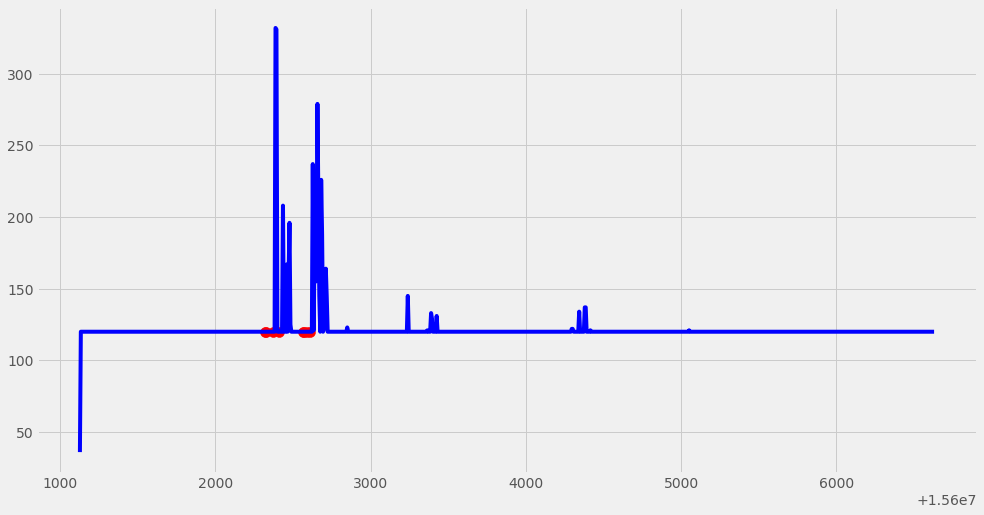

In [0]:
# data with anomaly label (test data part)
train = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
# complement = pd.Series(0, index=np.arange(len(diff)))
# # add the data to the main
df['anomaly28'] = train.append(complement, ignore_index='True')
print(df['anomaly28'].value_counts())

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly28'] == 1, ['time_epoch', 'count']] #anomaly

ax.plot(df['time_epoch'], df['count'], color='blue')
ax.scatter(a['time_epoch'],a['count'], color='red', s= 100)
# plt.axis([1.370*1e7, 1.405*1e7, -2.5,1])
plt.show()